## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, classification_report, 
                            confusion_matrix, roc_auc_score, roc_curve)
from imblearn.over_sampling import SMOTE
import joblib
import os

## 2. Load Dataset

In [2]:
def load_data(filepath):
    df = pd.read_csv(filepath)
    print("=== Dataset Preview ===")
    print("Head (5 rows):")
    print(df.head())
    print("\nTail (5 rows):")
    print(df.tail())
    print("\nDataset Info:")
    print(df.info())
    print("\nDescriptive Stats:")
    print(df.describe())
    return df

df = load_data("data.csv")

=== Dataset Preview ===
Head (5 rows):
    temp  max_temp  wind_speed  cloudcover  precip  humidity  class
0  29.90     37.00       23.00       58.60  146.00     83.86      1
1  93.04     82.41       63.44      102.42  192.07    129.30      1
2  87.13     98.82       72.29      122.12  191.80    142.25      1
3  92.12     72.39       73.84       96.50  196.53    150.42      1
4  92.64     76.03       67.13       92.61  191.76    126.61      1

Tail (5 rows):
       temp  max_temp  wind_speed  cloudcover  precip  humidity  class
5035  61.43     77.45       80.24       77.38   81.32    124.24      0
5036  72.26     78.98       47.48       73.92   67.72    113.09      0
5037  76.40     82.69       79.23       58.95   65.84    122.76      0
5038  61.03     74.17       70.44       61.39   64.09    106.96      0
5039  85.19     64.06       73.84       56.96   71.45    109.65      0

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5040 entries, 0 to 5039
Data columns (total 7 

## 3. Preprocess Data

In [3]:
# Clip outliers (adjust thresholds as needed)
df['precip'] = df['precip'].clip(upper=500)
df['humidity'] = df['humidity'].clip(upper=100)

# Handle missing values (if any)
if df.isnull().sum().any():
    df.fillna(df.median(), inplace=True)

## 4. Data Visualizations

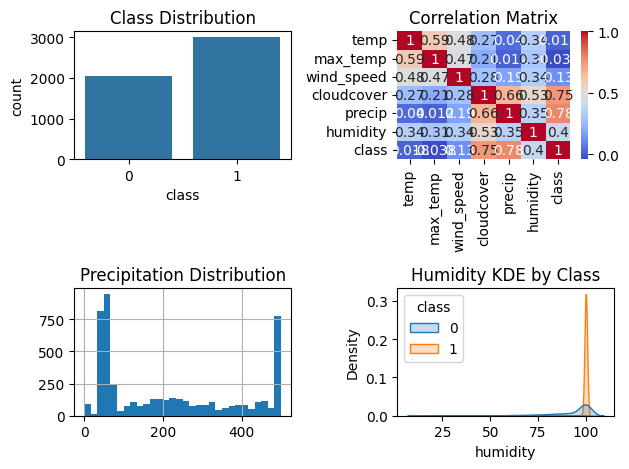

In [4]:
plt.subplot(2, 2, 1)
sns.countplot(x='class', data=df)
plt.title("Class Distribution")

# Correlation Heatmap
plt.subplot(2, 2, 2)
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")

# Feature Histograms
plt.subplot(2, 2, 3)
df['precip'].hist(bins=30)
plt.title("Precipitation Distribution")

# KDE Plot
plt.subplot(2, 2, 4)
sns.kdeplot(data=df, x='humidity', hue='class', fill=True)
plt.title("Humidity KDE by Class")

plt.tight_layout()
plt.savefig("eda_plots.png")
plt.show()


## 5. Prepare Data for Training

In [5]:
X = df.drop('class', axis=1)
y = df['class']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Handle Class Imbalance
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

## 6. Model Training

In [6]:
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    class_weight='balanced',
    random_state=42
)
model.fit(X_train_scaled, y_train_res)


RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=5, n_estimators=200, random_state=42)

## 7. Model Evaluation


=== Evaluation Metrics ===
Accuracy: 0.9861111111111112

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       408
           1       1.00      0.98      0.99       600

    accuracy                           0.99      1008
   macro avg       0.98      0.99      0.99      1008
weighted avg       0.99      0.99      0.99      1008



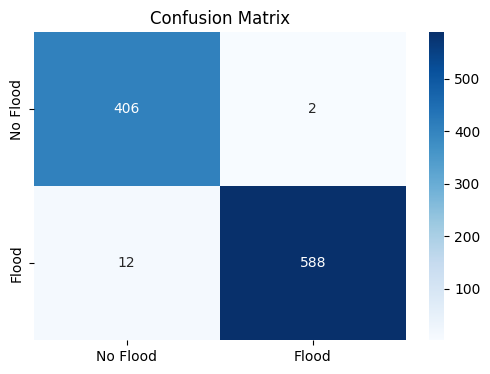

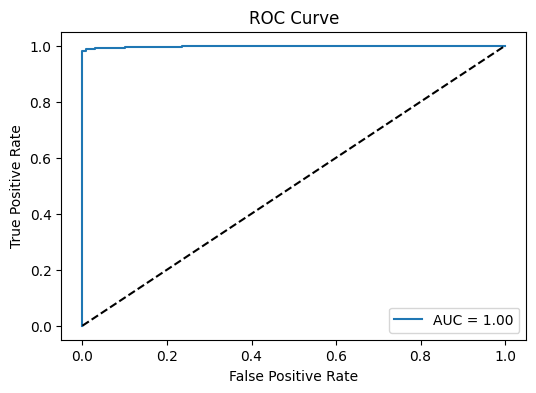

In [7]:
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

print("\n=== Evaluation Metrics ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Flood', 'Flood'],
            yticklabels=['No Flood', 'Flood'])
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.savefig("roc_curve.png")
plt.show()

## 8. Save Artifacts

In [8]:
joblib.dump(model, 'flood_model.pkl')
joblib.dump(scaler, 'flood_scaler.pkl')

print("\n=== Model Saved ===")
print("flood_model.pkl - Model saved in current directory")
print("flood_scaler.pkl - Scaler saved in current directory")


=== Model Saved ===
flood_model.pkl - Model saved in current directory
flood_scaler.pkl - Scaler saved in current directory
